In this notebook we produce an embedding using the technique of Node2vec similar to Word2vec (linguistic models). 
With this node embedding we compute the edge embedding and make a k-cross validation score against the weighted edges
of the network. 
The goal is to produce an embedding of edges that, given two nodes, provides the predicted sign of the link. 
For this purpose we have substituted the classes in the edges by only 2, positive and negative. 

In [1]:
import numpy as np
import pandas as pd 


import torch
import torch_geometric.data as data
from torch_geometric.nn import GCNConv
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.utils import negative_sampling,train_test_split_edges,to_dense_adj
from sklearn.metrics import roc_auc_score
from torch_geometric.transforms import RandomLinkSplit
from sklearn import preprocessing
from torch_geometric.nn import Node2Vec

device = "cpu"

In [2]:
nodes = pd.read_csv(r"Nodes_t1.csv",sep=",",encoding = 'unicode_escape')
edges = pd.read_csv(r"Edges_t1.csv",sep=";",encoding = 'unicode_escape')
edges["weight"] = edges["weight"].apply(lambda x: np.sign(x))
nodes[["ID"]] = nodes[["ID"]].apply(lambda x:x-edges["from"].min())
edges[["from","to"]] = edges[["from","to"]].apply(lambda x:x-edges["from"].min())
###Erase ESO 
nodes["Curso"] = nodes["Curso"].astype(str).str[0].astype("int64")
#del nodes["Unnamed: 0"]
nodes_dummy = pd.get_dummies(nodes)
x = nodes_dummy.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
nodes_norm = pd.DataFrame(x_scaled)

In [3]:
total_data = data.Data(x=torch.tensor(nodes_norm.to_numpy(),dtype=torch.float32),
                          edge_index=torch.tensor(edges[["from","to"]].to_numpy().T),
                          edge_attr=torch.tensor((pd.get_dummies(edges["weight"]).to_numpy())))

In [4]:
total_data

Data(x=[409, 12], edge_index=[2, 8557], edge_attr=[8557, 2])

In [5]:
import random as rd

node_list = list(range(len(nodes)))
rd.shuffle(node_list)
train_set = node_list[0:round(len(node_list)*0.7)]
val_set = node_list[round(len(node_list)*0.7):round(len(node_list)*0.85)]
test_set = node_list[round(len(node_list)*0.85):round(len(node_list)*1)]
rd.shuffle(test_set)
print(len(train_set),len(test_set),len(val_set))
print(len(train_set)+len(test_set)+len(val_set) == len(node_list))

print("train set\t",train_set[:10])
print("test set \t",test_set[:10])
print("val set  \t",val_set[:10])

286 61 62
True
train set	 [197, 131, 40, 166, 267, 6, 304, 181, 323, 30]
test set 	 [361, 329, 335, 315, 195, 113, 56, 183, 109, 320]
val set  	 [169, 15, 380, 239, 112, 121, 79, 390, 57, 83]


In [6]:
# build test train val masks

train_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in train_set:
    train_mask[i] = 1.

test_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in test_set:
    test_mask[i] = 1.
    
val_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in val_set:
    val_mask[i] = 1.
    
print("train mask \t",train_mask[0:15])
print("test mask  \t",test_mask[0:15])
print("val mask   \t",val_mask[0:15]) 

train mask 	 tensor([0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1])
test mask  	 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
val mask   	 tensor([1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0])


In [7]:
# add masks
total_data.train_mask = train_mask
total_data.test_mask = test_mask
total_data.val_mask = val_mask

print("after\t\t",total_data)

after		 Data(x=[409, 12], edge_index=[2, 8557], edge_attr=[8557, 2], train_mask=[409], test_mask=[409], val_mask=[409])


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Node2Vec(total_data.edge_index, embedding_dim=128, walk_length=40,
             context_size=20, walks_per_node=5,
             num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.005)


In [9]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[total_data.train_mask], total_data.y[total_data.train_mask],
                     z[total_data.test_mask], total_data.y[total_data.test_mask],
                     max_iter=10)
    return acc


for epoch in range(1, 121):
    loss = train()
    #acc = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')
        

Epoch: 10, Loss: 5.6147
Epoch: 20, Loss: 4.2580
Epoch: 30, Loss: 3.3551
Epoch: 40, Loss: 2.6887
Epoch: 50, Loss: 2.1975
Epoch: 60, Loss: 1.9145
Epoch: 70, Loss: 1.6319
Epoch: 80, Loss: 1.4562
Epoch: 90, Loss: 1.3354
Epoch: 100, Loss: 1.2321
Epoch: 110, Loss: 1.1587
Epoch: 120, Loss: 1.0918


In [10]:
z = model()

In [11]:
# from tensor to numpy
emb_128 = z.detach().cpu().numpy()

In [12]:
# convert edge attributes from categorical to numerical
edge_attr_cat = total_data.edge_attr.numpy()
print("Categorical edge attributes:\n",edge_attr_cat[:3])

edge_attr = []
for i in edge_attr_cat:
    edge_attr.append(np.nonzero(i)[0][0])

print("\n\nNumerical edge attributes:\n",edge_attr[:3])

Categorical edge attributes:
 [[1 0]
 [1 0]
 [0 1]]


Numerical edge attributes:
 [0, 0, 1]


### Compute edge embedding

In [30]:
edge_embedding = []
for u,v in total_data.edge_index.t():
    edge_embedding.append(np.mean([emb_128[u],emb_128[v]],0))
#edge_embedding = []
#for u,v in total_data.edge_index.t():
#    edge_embedding.append((abs(emb_128[u])/(abs(emb_128[u]) + abs(emb_128[v]))))

### Make dataframe from embedding and scale

In [31]:
emb_df = pd.concat([pd.DataFrame(edge_embedding),pd.DataFrame(edge_attr,columns=["label"])],axis=1)

In [32]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
sc = MinMaxScaler()

In [33]:
X = emb_df.drop("label",axis=1)
y = emb_df["label"]

emb_x_train, emb_x_test, emb_y_train, emb_y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=emb_df["label"])

In [34]:
sc.fit(emb_x_train)
emb_x_train = sc.transform(emb_x_train)
emb_x_test = sc.transform(emb_x_test)

### Oversample minority class

In [35]:
from imblearn.over_sampling import SMOTE

In [36]:
ros = SMOTE(random_state=0,sampling_strategy="minority")
emb_x_resampled, emb_y_resampled = ros.fit_resample(emb_x_train, emb_y_train)
emb_y_resampled = emb_y_resampled.values
emb_y_test = emb_y_test.values

### Training and prediction 

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [38]:
clf = RandomForestClassifier(max_depth=7,random_state=10,class_weight="balanced")


In [39]:
clf.fit(emb_x_resampled,emb_y_resampled)

RandomForestClassifier(class_weight='balanced', max_depth=7, random_state=10)



              precision    recall  f1-score   support

           0       0.45      0.53      0.49       251
           1       0.92      0.89      0.90      1461

    accuracy                           0.84      1712
   macro avg       0.68      0.71      0.69      1712
weighted avg       0.85      0.84      0.84      1712



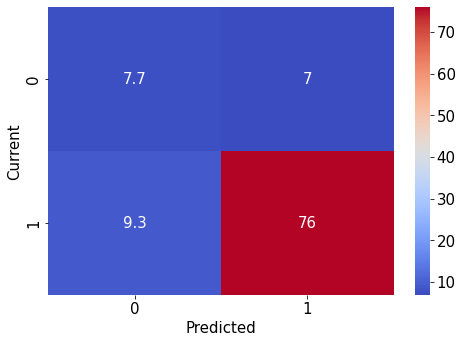

In [40]:
from sklearn.metrics import confusion_matrix,classification_report
fig= plt.figure()
ax = fig.add_axes([0,0,1,1])
sns.heatmap(np.round(confusion_matrix(emb_y_test,np.around(clf.predict(emb_x_test)))/len(emb_y_test)*100,2),
            annot=True,ax=ax,cmap="coolwarm")
ax.set_xlabel("Predicted")
ax.set_ylabel("Current")
print("\n")
print(classification_report(emb_y_test,clf.predict(emb_x_test)))


In [41]:
import tensorflow as tf

In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation="relu",input_shape=(emb_x_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32,activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8,activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation="sigmoid")
])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=10e-5),
         loss="binary_crossentropy",
             metrics=["accuracy"])
model_history = model.fit(emb_x_resampled,emb_y_resampled,validation_data=(emb_x_test,emb_y_test),epochs=500,verbose=1,batch_size=128,
                         callbacks=[tf.keras.callbacks.EarlyStopping(patience=25)])
                         

Epoch 1/500
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/home/juan/.local/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


85/92 [==========================>...] - ETA: 0s - loss: 0.7932 - accuracy: 0.4906WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fbc5cc23af0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
92/92 [==============================] - 1s 6ms/step - loss: 0.7901 - accuracy: 0.4905 - val_loss: 0.6964 - val_accuracy: 0.4463
Epoch 2/500
92/92 [===============

Epoch 52/500
92/92 [==============================] - 0s 4ms/step - loss: 0.6230 - accuracy: 0.6638 - val_loss: 0.6052 - val_accuracy: 0.7845
Epoch 53/500
92/92 [==============================] - 0s 4ms/step - loss: 0.6275 - accuracy: 0.6547 - val_loss: 0.5970 - val_accuracy: 0.8043
Epoch 54/500
92/92 [==============================] - 0s 4ms/step - loss: 0.6199 - accuracy: 0.6664 - val_loss: 0.6050 - val_accuracy: 0.7751
Epoch 55/500
92/92 [==============================] - 0s 4ms/step - loss: 0.6201 - accuracy: 0.6676 - val_loss: 0.5991 - val_accuracy: 0.7880
Epoch 56/500
92/92 [==============================] - 0s 4ms/step - loss: 0.6162 - accuracy: 0.6693 - val_loss: 0.5827 - val_accuracy: 0.8084
Epoch 57/500
92/92 [==============================] - 0s 4ms/step - loss: 0.6112 - accuracy: 0.6771 - val_loss: 0.5902 - val_accuracy: 0.7938
Epoch 58/500
92/92 [==============================] - 0s 3ms/step - loss: 0.6092 - accuracy: 0.6733 - val_loss: 0.5755 - val_accuracy: 0.8078
Epoch 

92/92 [==============================] - 0s 4ms/step - loss: 0.5183 - accuracy: 0.7667 - val_loss: 0.5210 - val_accuracy: 0.7675
Epoch 110/500
92/92 [==============================] - 0s 4ms/step - loss: 0.5164 - accuracy: 0.7651 - val_loss: 0.4946 - val_accuracy: 0.7979
Epoch 111/500
92/92 [==============================] - 0s 4ms/step - loss: 0.5145 - accuracy: 0.7689 - val_loss: 0.5025 - val_accuracy: 0.7891
Epoch 112/500
92/92 [==============================] - 0s 4ms/step - loss: 0.5146 - accuracy: 0.7674 - val_loss: 0.5107 - val_accuracy: 0.7792
Epoch 113/500
92/92 [==============================] - 0s 4ms/step - loss: 0.5161 - accuracy: 0.7704 - val_loss: 0.4960 - val_accuracy: 0.7956
Epoch 114/500
92/92 [==============================] - 0s 4ms/step - loss: 0.5056 - accuracy: 0.7743 - val_loss: 0.5000 - val_accuracy: 0.7938
Epoch 115/500
92/92 [==============================] - 0s 4ms/step - loss: 0.5116 - accuracy: 0.7732 - val_loss: 0.4855 - val_accuracy: 0.8008
Epoch 116/500

92/92 [==============================] - 1s 8ms/step - loss: 0.4507 - accuracy: 0.8099 - val_loss: 0.4596 - val_accuracy: 0.7996
Epoch 167/500
92/92 [==============================] - 1s 8ms/step - loss: 0.4495 - accuracy: 0.8117 - val_loss: 0.4434 - val_accuracy: 0.8107
Epoch 168/500
92/92 [==============================] - 1s 7ms/step - loss: 0.4568 - accuracy: 0.8100 - val_loss: 0.4681 - val_accuracy: 0.7950
Epoch 169/500
92/92 [==============================] - 0s 5ms/step - loss: 0.4563 - accuracy: 0.8106 - val_loss: 0.4969 - val_accuracy: 0.7815
Epoch 170/500
92/92 [==============================] - 1s 8ms/step - loss: 0.4471 - accuracy: 0.8164 - val_loss: 0.4555 - val_accuracy: 0.8043
Epoch 171/500
92/92 [==============================] - 1s 9ms/step - loss: 0.4436 - accuracy: 0.8165 - val_loss: 0.4550 - val_accuracy: 0.8014
Epoch 172/500
92/92 [==============================] - 0s 4ms/step - loss: 0.4494 - accuracy: 0.8152 - val_loss: 0.4668 - val_accuracy: 0.8020
Epoch 173/500

92/92 [==============================] - 1s 10ms/step - loss: 0.4047 - accuracy: 0.8341 - val_loss: 0.4739 - val_accuracy: 0.8032
Epoch 224/500
92/92 [==============================] - 1s 10ms/step - loss: 0.4011 - accuracy: 0.8409 - val_loss: 0.4331 - val_accuracy: 0.8248
Epoch 225/500
92/92 [==============================] - 1s 10ms/step - loss: 0.4066 - accuracy: 0.8403 - val_loss: 0.4357 - val_accuracy: 0.8189
Epoch 226/500
92/92 [==============================] - 1s 9ms/step - loss: 0.4086 - accuracy: 0.8450 - val_loss: 0.4568 - val_accuracy: 0.8049
Epoch 227/500
92/92 [==============================] - 1s 10ms/step - loss: 0.4080 - accuracy: 0.8387 - val_loss: 0.4394 - val_accuracy: 0.8143
Epoch 228/500
92/92 [==============================] - 1s 10ms/step - loss: 0.4098 - accuracy: 0.8364 - val_loss: 0.4770 - val_accuracy: 0.7938
Epoch 229/500
92/92 [==============================] - 1s 10ms/step - loss: 0.4084 - accuracy: 0.8407 - val_loss: 0.4585 - val_accuracy: 0.8072
Epoch 2

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


              precision    recall  f1-score   support

           0       0.43      0.52      0.47       251
           1       0.91      0.88      0.90      1461

    accuracy                           0.83      1712
   macro avg       0.67      0.70      0.68      1712
weighted avg       0.84      0.83      0.83      1712



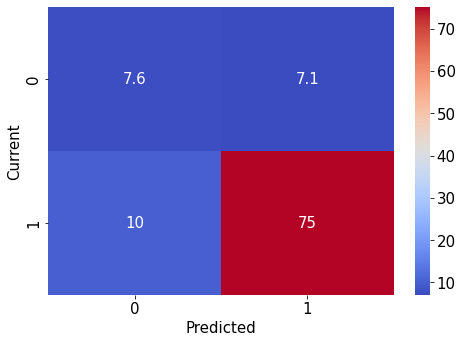

In [43]:
from sklearn.metrics import confusion_matrix,classification_report
fig= plt.figure()
ax = fig.add_axes([0,0,1,1])
sns.heatmap(np.round(confusion_matrix(emb_y_test,np.around(model.predict(emb_x_test)))/len(emb_y_test)*100,2),
            annot=True,ax=ax,cmap="coolwarm")
ax.set_xlabel("Predicted")
ax.set_ylabel("Current")
print("\n")
print(classification_report(emb_y_test,np.around(model.predict(emb_x_test))))


<AxesSubplot:>

<Figure size 864x576 with 0 Axes>

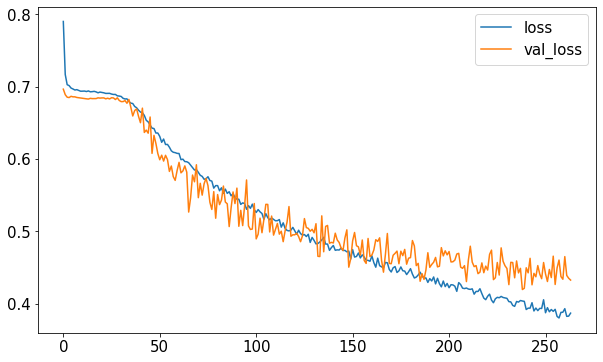

In [44]:
fig = plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 15})
pd.DataFrame(model_history.history)[["loss","val_loss"]].plot(figsize=(10,6))

<AxesSubplot:>

<Figure size 864x576 with 0 Axes>

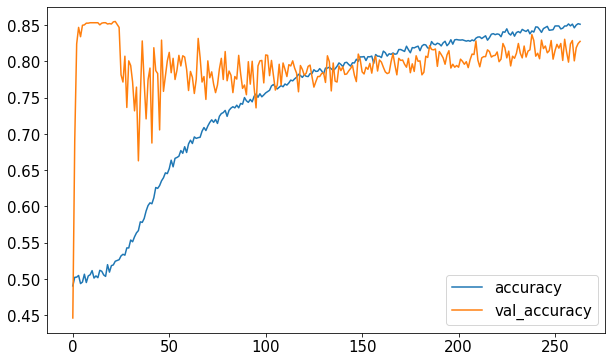

In [45]:
fig = plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 15})
pd.DataFrame(model_history.history)[["accuracy","val_accuracy"]].plot(figsize=(10,6))

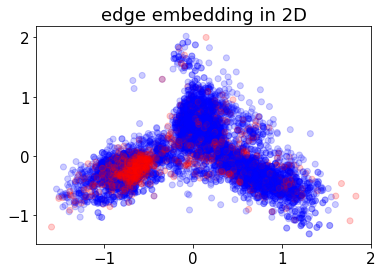

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# fit and transform using PCA
pca = PCA(n_components=2)
edge_emb2d = pca.fit_transform(X)



df = pd.DataFrame(dict(edge_att=y))
colors = {0:"red",1:"blue"}
plt.title("edge embedding in 2D")
plt.scatter(edge_emb2d[:,0],edge_emb2d[:,1],c=df.edge_att.map(colors),alpha=0.2)
plt.show()

# not so good but we are using PCA to reduce the dim from 128 to 2